# Introduction
In this homework we are tasked to:
* build and backtest 2 strategies - HODL and SMA crossover
* use the TSLA stock prices from 1/1/2020 to 6/1/2021
* use various values for the short SMA from 20 - 40 in steps of 1 and the long SMA from 150-250 in steps of 5
* make CAGR and Daily Sharpe heatmaps of the SMA combinations 
* plot and compare the best SMA strategy wit the HODL strategy

# Description of Strategies

## HODL
The HODL strategy is run once and the stock is bought in the start and never bought or sold again. This strategy is encouraged when you trust the growth of an asset and are with them for the long run. The purpose of this strategy in the context of this assignment is to have a benchmark to compare the optimized SMA strategy and see how much better it performs. 

## SMA Optimization
Strategy used was a trend following strategy. **Trend following**, also known as a momentum strategy, **bets that the price trend will continue in the same direction**. When the price rises above its moving average, enter a long position to bet the price will continue to rise. 

* **long signal**: When the short-term SMA crosses above the long-term SMA, as it suggests the price is picking up momentum. 

* **short signal**: When the short-term SMA crosses below the long-term SMA, as it suggests that the price is losing momentum.

We use these signals to trigger a buy/sell response. 
Here the signal is not constructed directly from the price comparison, so we will use **bt.algos.WeighTarget()** and pass the signal DataFrame. 

The signal value 1, -1 or 0 will dictate which period we will have long positions, short positions, or no positions.
_______________
In order to construct a better strategy in a specific range, a loop was constructed with varying number.

* **Short Signal**: 41 different number of days were test ranging from 20 to 40 with intervals of 1. 
* **Long Signal**: 21 different number of days were test ranging from 150 to 250 with intervals of 5.
    
Each short signal was used with each long signal. 


# Choosing the Optimum SMA strategy
Next, two heatmaps (Figure 1 and 2) were constructed depicting the CAGR and Daily Sharpe ratio of each of the 41x21 SMA combinations and the strategy with the highest values was used. The CAGR heat map shows that smaller long signals (~150 days). Maybe a better CAGR would be obtained with smaller values than 150. The Daily Sharpe ratio heatmap is more sporadic but it too shows that a smaller long signal is a better choice given the set of small signals.

The optimal strategy has a short signal of 31 days and a long signal of 150 days with a CAGR and Daily Sharpe ratio of 0.72 and 1.3, respectively. 


## Figure 1
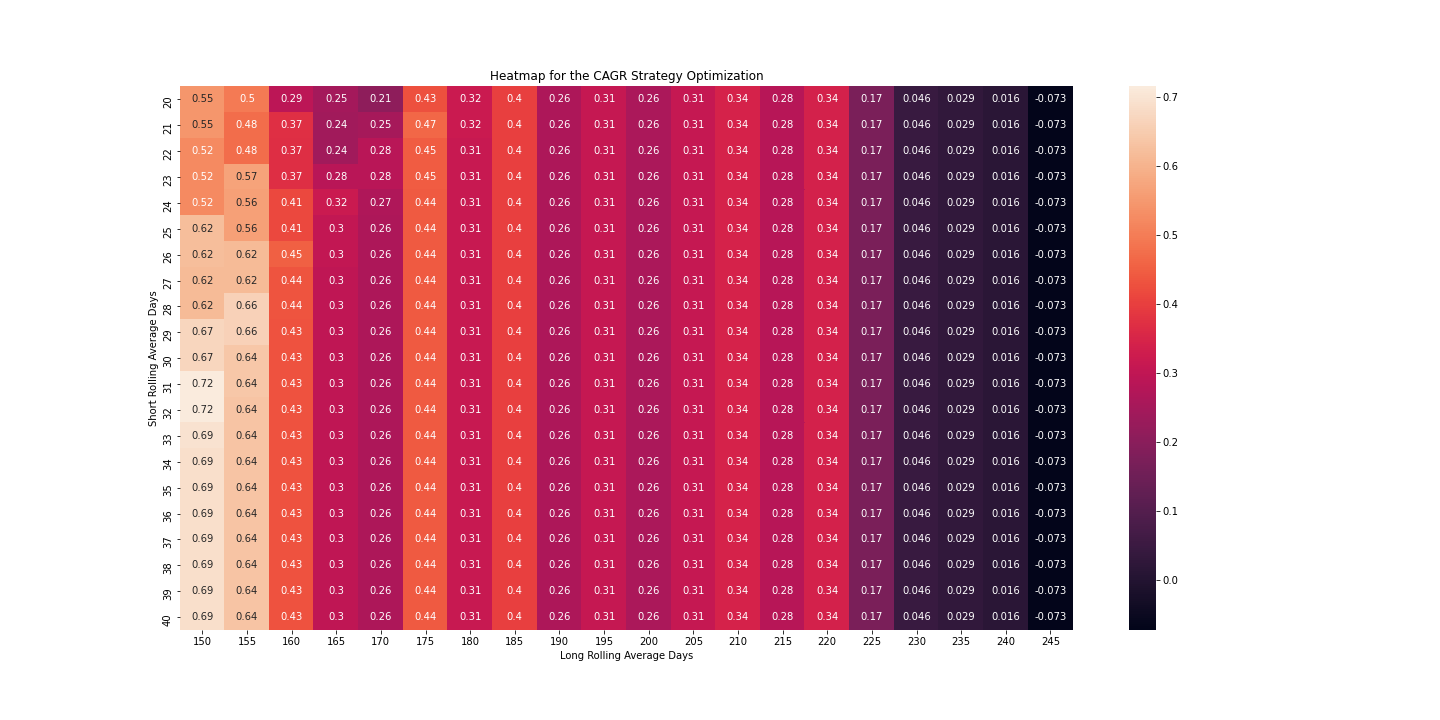

## Figure 2
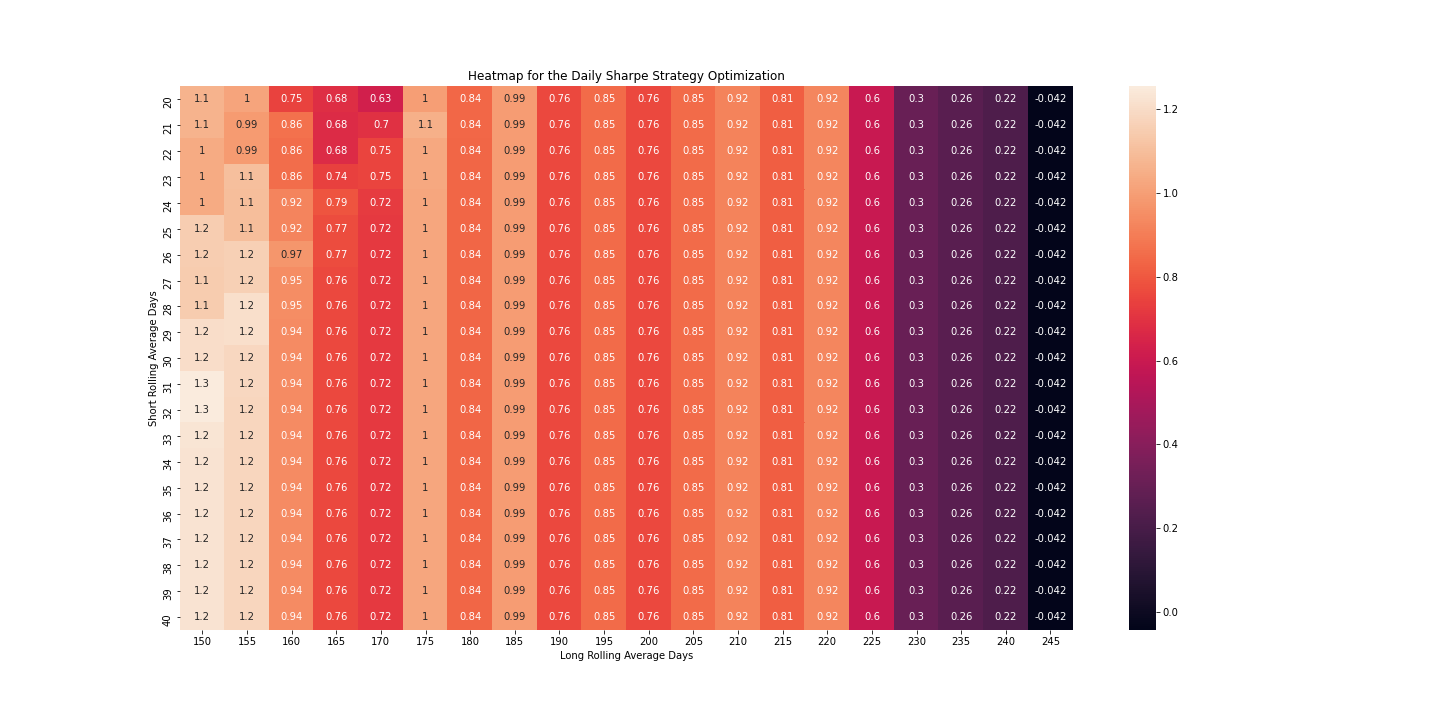

# Comparing the HODL and Optimized SMA strategies
The HODL strategy and the optimized strategy were backtested and plotted against each other. The result is plotted below (Figure 3). The HODL strategy did better throughout most of the backtested period. Out of the entire short and long space combinations, the optimum SMA strategy was unable to even cross the 300 index in contrast to ~1000 index maximum of the HODL strategy. 

## Figure 3
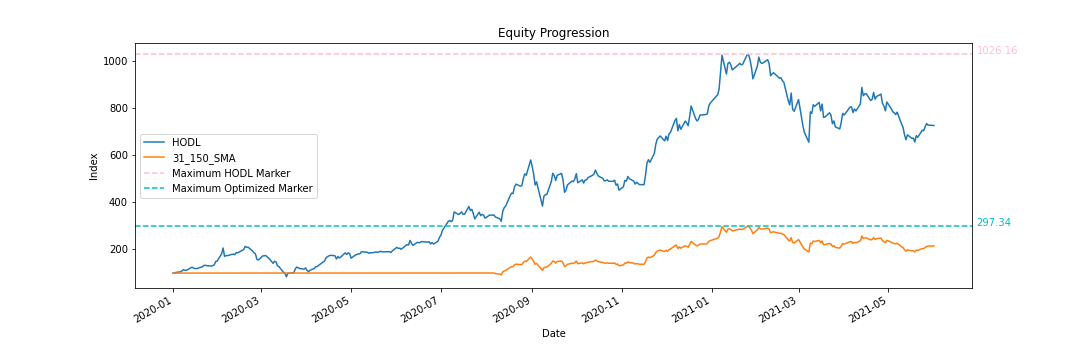

# Conclusion
The biggest insight we get from the exercise is that just because we use sophisticated tools to automate trading does not mean that we would do better in the stock market. These tools are to aid our analysis and intuition of the market and not the other way around. Even though we swept a large space to find an optimal SMA strategy, we still fared much worse than a basic buy and hold strategy. 

In [1]:
import bt
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
pd.set_option("display.max_rows", None, "display.max_columns", None)

In [2]:
stock_data = bt.get('tsla', start='2020-1-1', end='2021-6-1')

In [3]:
short_period_range = np.arange(20, 41, 1)
long_period_range = np.arange(150, 250, 5)

cagr_df = pd.DataFrame()
daily_sharpe_df = pd.DataFrame()
results_dict = {}

bt_return = 0 
for short in short_period_range:
    for long in long_period_range:
        short_sma_df_temp = stock_data.rolling(short).mean()
        long_sma_df_temp = stock_data.rolling(long).mean()

        # Create the signals DF
        signal = long_sma_df_temp.copy()
        signal[long_sma_df_temp.isnull()] = 0

        # Define the signal
        signal[short_sma_df_temp > long_sma_df_temp] = 1
        signal[short_sma_df_temp < long_sma_df_temp] = -1


        bt_short_strategy1 = bt.Strategy(f'{short}_{long}_SMA',
                                    [bt.algos.WeighTarget(signal),
                                     bt.algos.Rebalance()])

        bt_short_backtest1 = bt.Backtest(bt_short_strategy1, stock_data)
        bt_short_result1 = bt.run(bt_short_backtest1)
        
        cagr_df.loc[short,long] = float(bt_short_result1.stats.loc['cagr',:])
        daily_sharpe_df.loc[short,long] = float(bt_short_result1.stats.loc['daily_sharpe',:])
        
        results_dict[f'{short}_{long}_result'] = bt_short_result1
        
        

In [4]:
for col in cagr_df.columns:
    cagr_df[col] = cagr_df[col].astype(float)

for col in daily_sharpe_df.columns:
    daily_sharpe_df[col] = daily_sharpe_df[col].astype(float)
    

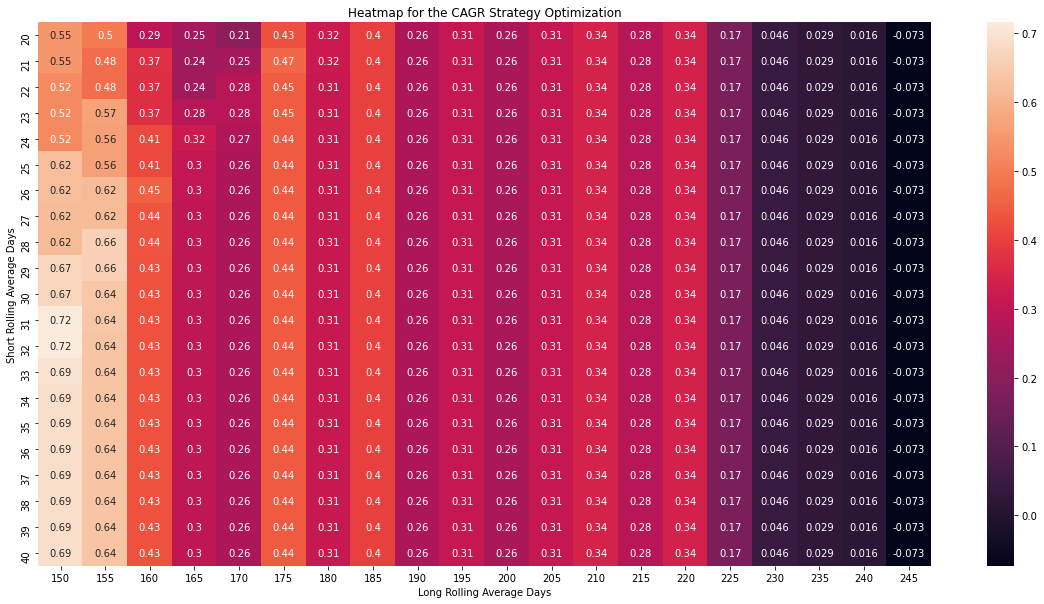

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cagr_df, annot=True)
plt.title('Heatmap for the CAGR Strategy Optimization')
plt.ylabel('Short Rolling Average Days')
plt.xlabel('Long Rolling Average Days')
plt.savefig('CAGR_heatmap.png')
plt.show()

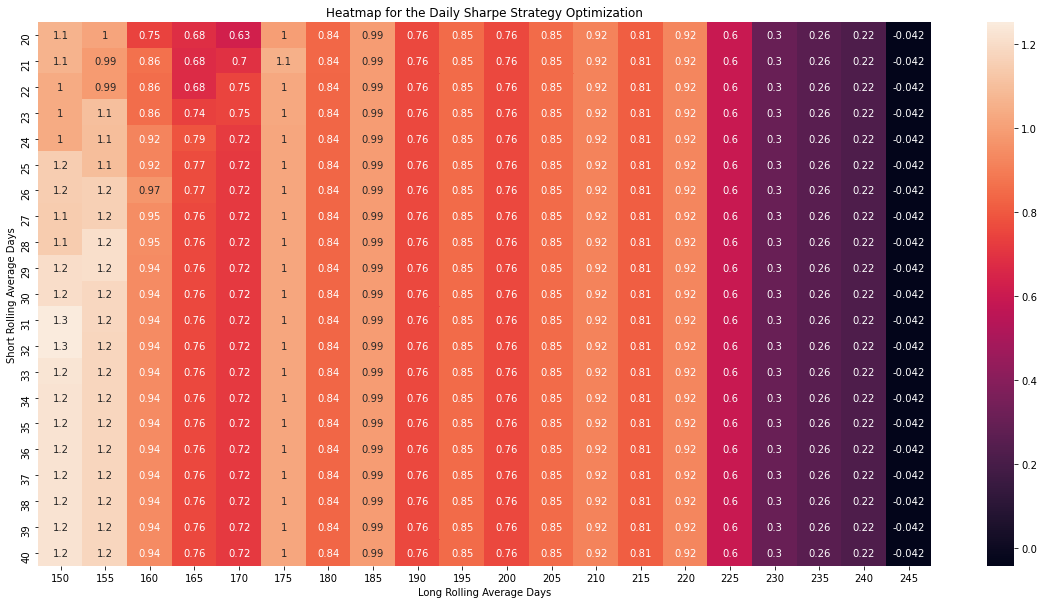

In [13]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(daily_sharpe_df, annot=True)
plt.title('Heatmap for the Daily Sharpe Strategy Optimization')
plt.ylabel('Short Rolling Average Days')
plt.xlabel('Long Rolling Average Days')
plt.savefig('daily_sharpe_heatmap.png')
plt.show()

In [7]:
max_sharpe = 0
strategy = ''
for key in results_dict.keys():
    if float(results_dict[key].stats.loc['daily_sharpe']) > max_sharpe:
        max_sharpe = float(results_dict[key].stats.loc['daily_sharpe'])
        strategy = key
        
print(float(max_sharpe))
print(str(strategy))

1.252977792561247
31_150_result


In [8]:
s = bt.Strategy('HODL',[bt.algos.RunOnce(),
                               bt.algos.SelectAll(),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])
hodl_bt = bt.Backtest(s, stock_data)
hodl_res = bt.run(hodl_bt)



final_strategy = results_dict[strategy]


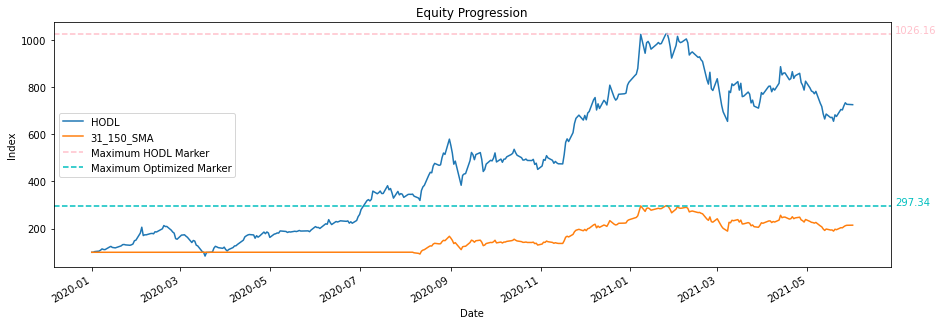

In [47]:
ax = hodl_res.plot()
final_strategy.plot(ax=ax)

plt.axhline(y=round(float(hodl_res.prices.max()),2), color='pink', linestyle='--', label='Maximum HODL Marker')
plt.text('2021-6-30',round(float(hodl_res.prices.max()),2),round(float(hodl_res.prices.max()),2), color='pink')

plt.axhline(y=round(float(final_strategy.prices.max()),2), color='c', linestyle='--', label='Maximum Optimized Marker')
plt.text('2021-6-30',round(float(final_strategy.prices.max()),2),round(float(final_strategy.prices.max()),2), color='c')

plt.ylabel('Index')
plt.xlabel('Date')
plt.legend()
plt.savefig('equity_progression.png')